In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
import seaborn as sns
sns.set(style="ticks")
import plotly.graph_objects as go
import plotly.express as px

<Figure size 720x432 with 0 Axes>

## Loading data and joining

In [11]:
df = pd.read_excel(r'C:\Users\79534\Documents\Articles\data\IMDT.xlsx')
df['year_ccode1'] = df['year'].astype(str) + '_'+ df['ccode1'].astype(str)
corwar = pd.read_excel(r'C:\Users\79534\Documents\Articles\corwar\IMDT.xlsx')
corwar['year_ccode1'] = corwar['year'].astype(str) + '_'+ corwar['ccode1'].astype(str)
df = df.merge(corwar[['year_ccode1', 'military_personnel_']])

## Variables and their distribution

**Troops** - number of deployed military personnel

In [12]:
df['Troops'].describe()

count     18796.000000
mean       1349.817727
std       10209.976572
min           1.000000
25%           4.000000
50%          20.000000
75%         306.250000
max      380000.000000
Name: Troops, dtype: float64

The minimal number - 1 deployed soldier. Most often - blue masks, a part of a *peacekeeping force*.

In [13]:
df[df.Troops==1]['Peacekeeping'].mean()

0.7782936738247244

The maximum value - 380 000 deployed soldiers by Soviet Union to a Eastern Germany, as a strategic place of Cold War confrontation.

In [14]:
df[df.Troops==380000][['deployer','host','year']]

,deployer,host,year
9601,Russia,German Democratic Republic,1985
9625,Russia,German Democratic Republic,1986


In [ ]:
Throughout 37 years that are covered by our data set 

C:\Users\79534\AppData\Local\Temp/ipykernel_10084/3741221755.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  germany['Alliance']  = np.where(germany['ccode1']==365, 'Soviet Union', 'US and its allies')


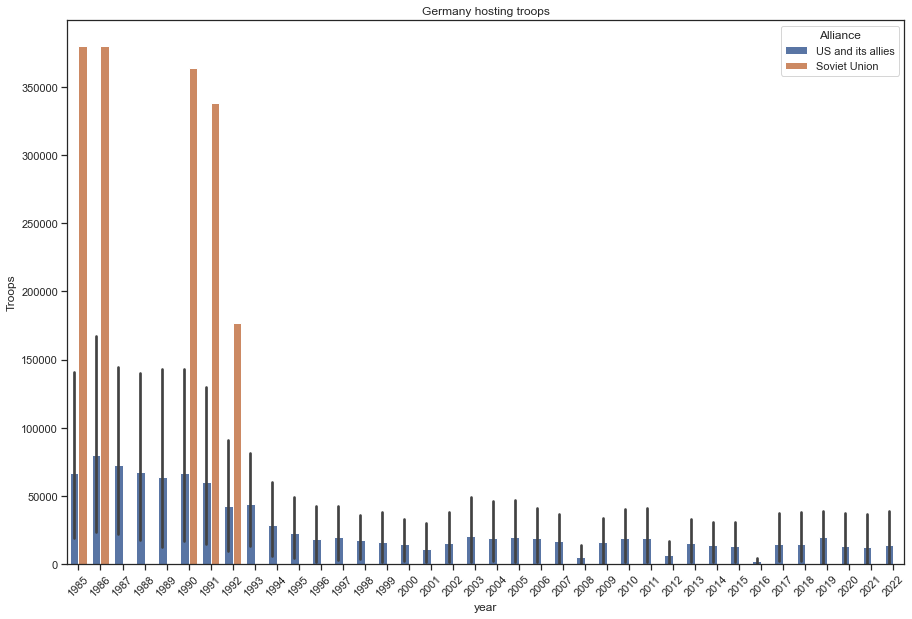

In [31]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
germany = df[df.ccode2.isin([255, 260,265])]
germany['Alliance']  = np.where(germany['ccode1']==365, 'Soviet Union', 'US and its allies')
sns.barplot(data=germany, x='year', y='Troops', hue='Alliance').set(title='Germany hosting troops');

## Data as network

In [ ]:
df= df.rename(columns = {'deployer':'Source', 'host':'Target', 'Troops':'Weight'})
df.dropna(subset = ['Weight'], inplace=True)
df.head()

In [6]:
years = [1985, 1990, 1995, 2000, 2005,2010, 2015, 2020, 2022]
nets = []
for i in years:
    df_year = df[df.year==i]
    G = nx.from_pandas_edgelist(df_year,  source='Source', target='Target', edge_attr='Weight')
    nets.append(G)

In [ ]:
nx.draw(g)

In [8]:
nets = []
for i in df['year'].unique():
    df_year = df[df.year==i]
    G = nx.from_pandas_edgelist(df_year,  source='Source', target='Target', edge_attr='Weight')
    nets.append(G)

In [23]:
metrics = pd.DataFrame({'year': list( df['year'].unique()),
                      'network': nets})
metrics['density'] = metrics['network'].apply(lambda x :nx.density(x) )
metrics['transitivity'] = metrics['network'].apply(lambda x :nx.transitivity(x) )
metrics['average_clustering_coefficient'] = metrics['network'].apply(lambda x :nx.algorithms.approximation.clustering_coefficient.average_clustering(x) )
metrics['edges_quantity'] = metrics['network'].apply(lambda x :x.number_of_edges() )
metrics['nodes_quantity'] =  metrics['network'].apply(lambda x :x.number_of_nodes() )
metrics['average_degree'] = metrics['edges_quantity'] / metrics['nodes_quantity']
metrics.head()

,year,network,density,transitivity,average_clustering_coefficient,edges_quantity,nodes_quantity,average_degree
0,1985,"(United States , United Kingdom, Netherlands, ...",0.037650,0.095491,0.172,116,79,1.468354
1,1986,"(United States , United Kingdom, Netherlands, ...",0.035858,0.082786,0.164,125,84,1.488095
2,1987,"(United States , Netherlands, Belgium, German ...",0.036630,0.062176,0.093,110,78,1.410256
3,1988,"(United States , United Kingdom, Netherlands, ...",0.034810,0.059459,0.062,110,80,1.375000
4,1989,"(United States , United Kingdom, Netherlands, ...",0.042017,0.056485,0.105,150,85,1.764706


In [29]:
metrics.columns

Index(['year', 'network', 'density', 'transitivity',
       'average_clustering_coefficient', 'edges_quantity', 'nodes_quantity',
       'average_degree'],
      dtype='object')

In [27]:
metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
year,38.0,2003.500000,11.113055,1985.000000,1994.250000,2003.500000,2012.750000,2022.000000
density,38.0,0.059334,0.011685,0.034810,0.051437,0.063156,0.067896,0.075070
transitivity,38.0,0.102702,0.026839,0.056485,0.083253,0.103343,0.120541,0.163974
average_clustering_coefficient,38.0,0.179263,0.069892,0.062000,0.129750,0.162500,0.223750,0.390000
edges_quantity,38.0,490.421053,219.979315,110.000000,357.500000,526.500000,661.750000,890.000000
nodes_quantity,38.0,123.789474,23.257847,78.000000,109.000000,131.000000,142.750000,167.000000
average_degree,38.0,3.748596,1.233834,1.375000,3.048687,4.028226,4.691421,5.329341


In [32]:
metrics = pd.melt(metrics, id_vars =['year'], var_name='metrics', value_vars =['density', 'transitivity',
       'average_clustering_coefficient', 'edges_quantity', 'nodes_quantity',
       'average_degree'])

<AxesSubplot:xlabel='year', ylabel='value'>

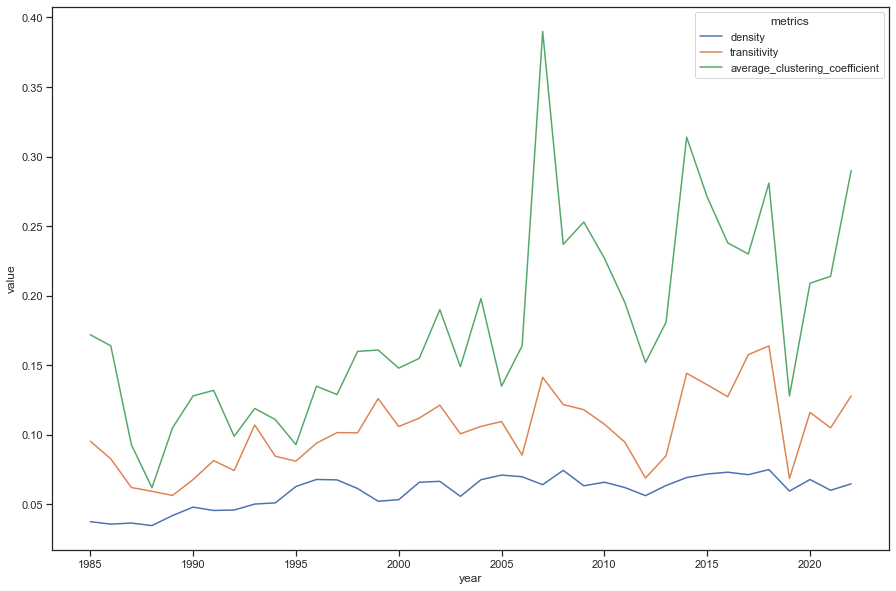

In [45]:
plt.figure(figsize=(15,10))
sns.lineplot(y='value', x='year',hue='metrics', data=metrics[metrics.metrics.isin(['year','density', 'transitivity',
       'average_clustering_coefficient'])])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              